# Управление с непрерывными действиями (Continuous Control) (<span style="color: green"> 10 баллов за основную часть + 5 баллов за бонусную часть</span>)

#### Дедлайн (жёсткий) задания: 04.05.2025,  UTC+3

#### При сдаче задания нужно  поместить в архив данный файл и папки с логами и видео, сохраняя относительные пути, и послать архив в систему сдачи.

### <span style="color: red"> Если работа была списана и/или сделана LLM, то за работу ставится 0 баллов. </span> 

В этом домашнем задании предлагается решить задачу управления с непрерывными действиями, используя алгоритмы:

- **Twin Delayed DDPG (TD3)** (**Раздел 6.1.6 (Алгоритм 23)**)
- **Soft Actor-Critic (SAC)** (**Раздел 6.2.4 (Алгоритм 24)**)

Оба алгоритма являются off-policy и считаются одними из наиболее эффективных для задач управления в непрерывном пространстве действий. Они основаны на базовом алгоритме **Deep Deterministic Policy Gradient (DDPG)** (**Раздел 6.1.5 (Алгоритм 22)**), который можно представить как "DQN с отдельной нейросетью для аппроксимации жадной политики". Основные отличия заключаются в различных стабилизационных приёмах:

- TD3 обучает детерминированную политику, тогда как SAC использует стохастическую политику. Это означает, что в SAC достаточно просто сэмплировать действия из политики для исследования, в то время как в TD3 необходимо вручную добавлять шум к действиям.
- TD3 добавляет к действиям обрезанный шум (clipped noise) при расчёте целевых значений, что помогает бороться с переоценкой. SAC использует формализм максимальной энтропии и добавляет бонус за энтропию в функцию ценности, поощряя более разнообразные действия.

# Работа выполнена: Вицын Семён Сергеевич, Б05-131.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from queue import deque
from pathlib import Path
from IPython.display import HTML

import gymnasium as gym
from gymnasium.wrappers import RecordVideo

import torch
import torch.nn as nn
from torch.distributions import Normal

from logger import TensorboardSummaries as Summaries

In [28]:
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cpu"
DEVICE

'cpu'

## Среда

Сначала мы создадим экземпляр среды.

In [29]:
env = gym.make("BipedalWalker-v3", render_mode="rgb_array")

env.reset()

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print("Размерность вектора состояний dim =", state_dim)
print("n_actions =", action_dim)

Размерность вектора состояний dim = 24
n_actions = 4


Посмотрим на среду.

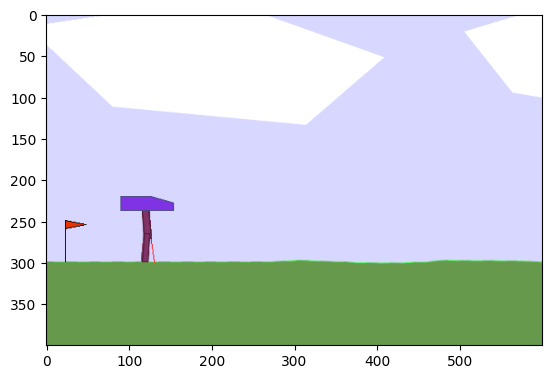

In [30]:
plt.imshow(env.render());

Давайте посмотрим на случайную политику и посмотрим, как это выглядит.

In [31]:
class RandomActor():
    def get_action(self, states):
        assert len(states.shape) == 1, "Не работает с батчами"
        return env.action_space.sample()

In [32]:
s, _ = env.reset()
rewards_per_step = []
actor = RandomActor()

for i in range(10000):
    a = actor.get_action(s)
    s, r, terminated, truncated, _ = env.step(a)

    rewards_per_step.append(r)

    if terminated or truncated:
        s, _ = env.reset()
        print("done: ", i)

done:  1599
done:  1685
done:  1746
done:  1806
done:  3406
done:  5006
done:  6606
done:  6679
done:  8279
done:  8335
done:  9935


В основном, каждый эпизод длится **1600 шагов** &mdash; это ограничение по времени, после которого происходит завершение эпизода. Однако иногда эпизод завершается раньше, если симуляция "понимает", что агент, например, **упал** или **разбился** &mdash; то есть ситуация явно неудачная для продолжения.

Посмотрим, что мы получаем при использовании случайной политики.

In [57]:
def evaluate(env, actor, n_games=1, t_max=1600):
    '''
    Запускает n_games эпизодов и возвращает массив наград.
    
    Возвращает
    -------
    rewards: np.array
        Массив наград
    '''
    rewards = []

    for _ in range(n_games):
        s, _ = env.reset()
        R = 0

        for _ in range(t_max):
            
            action = actor.get_action(torch.tensor(s).to(DEVICE))

            assert (action.max() <= 1).all() and  (action.min() >= -1).all()

            s, r, terminated, truncated, _ = env.step(action)

            R += r

            if terminated or truncated:
                break

        rewards.append(R)

    return np.array(rewards)

In [34]:
with RecordVideo(
    env = gym.make("BipedalWalker-v3", render_mode="rgb_array"),
    video_folder="./videos_test"
) as env_monitor:
    evaluate(env_monitor, actor, n_games=1, t_max=300)

/home/semyon/.local/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/semyon/ML/RL/ContinuousControl/videos_test folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /home/semyon/ML/RL/ContinuousControl/videos_test/rl-video-episode-0.mp4.
Moviepy - Writing video /home/semyon/ML/RL/ContinuousControl/videos_test/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/ContinuousControl/videos_test/rl-video-episode-0.mp4


In [35]:
video_paths = sorted([s for s in Path('videos_test').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]

data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

# Буфер

То же самое, что и в DQN. Вы можете просто скопировать код из вашего задания по DQN.

#### Напомним интерфейс:
* `exp_replay.add(obs, act, rw, next_obs, done)`  &mdash; сохраняет кортеж (s,a,r,s',done) в буфер
* `exp_replay.sample(batch_size)` &mdash; возвращает наблюдения, действия, награды, следующие наблюдения и is_done для `batch_size` случайных сэмплов.
* `len(exp_replay)` &mdash; возвращает количество элементов, хранящихся в буфере на данный момент.

In [36]:
import random

class ReplayBuffer(object):
    def __init__(self, size, alpha=0.6):
        """
        Создаёт буфер реплеев.
        Параметры
        ----------
        size: int
            Максимальное количество хранящихся единовременно переходов. При переполнении буфера старые
            записи удаляются.

        Замечание: для данного задания можно выбрать любую структуру данных.
              Если Вам достаточно простого решения, то можно просто хранить список кортежей (s, a, r, s')
              в self._storage. Однако, можно найти более быстрые и/или эффективные по памяти способы
              реализации самого хранения переходов.
        """
        #self._storage = []
        self._storage = deque(maxlen=size)
        self._maxsize = size
        self._priorities = deque(maxlen=size)
        self._alpha = alpha

    def __len__(self):
        return len(self._storage)

    def add_random(self, obs_t, action, reward, obs_tp1, done):
        '''
        Убедитесь, что _storage не превзойдёт по размерам _maxsize.
        Убедитесь, что FIFO правило выполняется: старейшие прецеденты должны удаляться раньше всех.
        '''
        data = (obs_t, action, reward, obs_tp1, done)
        self._storage.append(data)

    def sample_random(self, batch_size):
        """Сэмплирование батча переходов.
        Параметры
        ----------
        batch_size: int
            Сколько переходов сэмплировать.
        Возвращает
        -------
        obs_batch: np.array
            батч наблюдений (состояний)
        act_batch: np.array
            батч действий, выполненных на основе obs_batch
        rew_batch: np.array
            награды, полученные в качестве результата выполнения act_batch
        next_obs_batch: np.array
            следующие наблюдения (состояния), полученные после выполнения act_batch
        done_mask: np.array
            done_mask[i] = 1, если выполнение act_batch[i] повлекло
            окончание эпизода и 0 иначе.
        """
        #storage = self._storage

        #< случайно сгенерировать batch_size индексов сэмплов в буфере >
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]

        # собрать <s,a,r,s',done> для каждого индекса
        states, actions, rewards, next_states, is_dones = [], [], [], [], []
        for idx in idxes:
            state, action, reward, next_state, is_done = self._storage[idx]
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            is_dones.append(is_done)

        # < states > , < actions >, < rewards >,  < next_states >, < is_done >
        return (np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(is_dones))

Протестим.

In [37]:
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add_random(env.reset()[0], env.action_space.sample(), 1.0, env.reset()[0], done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample_random(5)

assert len(exp_replay) == 10, "Размер буфера должен быть равен 10, потому что это максимальная вместимость"

Функция для записи в буффер.

In [38]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Играется в среде ровно n шагов и записывается каждая пятёрка (s, a, r, s', done) в буффер.

    Возвращает
    -------
        sum_rewards: float
            суммарную награду за n шагов.
        s: float
            состояние, в котором осталась среда.
    """
    s = initial_state
    sum_rewards = 0

    for t in range(n_steps):
        
        a = agent.get_action(torch.tensor(s).to(DEVICE))
        
        ns, r, terminated, truncated, _ = env.step(a)
        
        exp_replay.add_random(s, a, r, ns, terminated)
        
        s = env.reset()[0] if terminated or truncated else ns
        
        sum_rewards += r        

    return sum_rewards, s

# Критик

Давайте начнём с модели критика &mdash; она одинаковая для **TD3** и **SAC**. С одной стороны, он будет приближать оптимальную функцию $Q^*(s, a)$, а с другой &mdash; оценивать текущего актора $\pi$, то есть рассматриваться как 
$Q^{\pi}(s, a)$. Этот критик принимает на вход как состояние $s$, так и действие $a$, а на выходе выдаёт скалярное значение.

Важно: если модель возвращает скаляр на выходе, хорошей практикой является применение .squeeze(), чтобы избежать неожиданного broadcast-а, поскольку тензор формы [batch_size, 1] может автоматически расширяться при операциях с другими тензорами.

Рекомендуемая архитектура &mdash; полносвязная нейросеть (MLP) с тремя слоями.

<span style="color: green"> __(1 балла)__ </span>

In [39]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()  
        
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim

        self.model = nn.Sequential(
            nn.Linear(self.state_dim + self.action_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(self.hidden_dim // 2, 1)
        )
        
    def forward(self, states, actions):
        input = torch.cat((states, actions), dim=-1)
        output = self.model(input)

        return output

    def get_qvalues(self, states, actions):
        '''
        Возвращает qvalues
        
        Параметры
        ----------
        states: torch.tensor [batch_size x features]
        actions: torch.tensor [batch_size x actions_dim]
            
        Возвращает
        -------
        qvalues: torch.tensor [batch_size]
        '''
        qvalues = self.forward(states, actions).squeeze()

        assert len(qvalues.shape) == 1 and qvalues.shape[0] == states.shape[0]
        
        return qvalues

# TD3

In [40]:
env = gym.make("BipedalWalker-v3", render_mode="rgb_array")
env = Summaries(env, "TD3")

Определим политику, или актора $\pi$. Необходимо смоделировать детерминированную политику. То есть, модель должна возвращать `action_dim` чисел в диапазоне $[-1, 1]$. К сожалению, детерминированные политики могут вызывать проблемы со стабильностью и исследованием, поэтому нам потребуется реализовать три "режима" работы этой политики:

1. Первый режим &mdash; **жадный** &mdash; это просто прямой проход через сеть. Он будет использоваться для обучения актора.
2. Второй режим &mdash; **режим исследования** &mdash; когда нужно добавить шум (например, гауссовский), чтобы собирать более разнообразные данные.
3. Третий режим &mdash; **"обрезанный шум"** &mdash; используется при расчёте целевого значения для критика. Здесь мы хотим добавить шум к выходу актора, но не слишком сильный, поэтому используем обрезанный шум:
$$\pi_{\theta}(s) + \varepsilon, \quad \varepsilon = \operatorname{clip}(\epsilon, -0.5, 0.5), \quad \epsilon \sim \mathcal{N}(0, \sigma^2 I)$$

Рекомендуемая архитектура &mdash; полносвязная нейронная сеть (MLP) с тремя слоями.

<span style="color: green"> __(2 балла)__ </span>

In [41]:
class TD3_Actor(nn.Module):
    def __init__(self, state_dim, action_dim, device, hidden_dim=256):
        super().__init__() 
        self.device = device
        
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim

        self.model = nn.Sequential(
            nn.Linear(self.state_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(self.hidden_dim // 2, self.action_dim),
            nn.Tanh()
        )
        
    def forward(self, state):
        output = self.model(state)

        return output
    
    def get_best_action(self, states):
        '''
        Используется для оптимизации актора.
        Требуется, чтобы действия были дифференцируемыми по параметрам модели.
        
        Параметры
        ----------
        states: torch.tensor [batch_size x features]
            
        Возвращает
        -------
        actions: torch.tensor [batch_size x actions_dim]
        '''
        actions = self.forward(states)

        return actions
        
    def get_action(self, states, std_noise=0.1):
        '''
        Используется для взаимодействия с окружающей средой и сбора данных.
        Поэтому к действиям необходимо добавлять шум.
        
        Параметры
        ----------
        states: np.array [batch_size x features]
        std_noise: float
        
        Возвращает
        -------
        actions: np.array [batch_size x actions_dim]
        '''
        # Градиенты тут не нужны, так как используется только для взаимодействия
        with torch.no_grad():
            actions = self.forward(states)
            noise = torch.randn_like(actions) * std_noise
            actions = torch.clip(actions + noise, -1, 1)

            assert actions.max() <= 1. and actions.min() >= -1,\
                "Действия должны находиться в диапазоне [-1, 1]"
        return actions.data.cpu().numpy()

    
    def get_target_action(self, states, std_noise=0.2, clip_eta=0.5):
        '''
        Используется для генерации целевых значений при обучении критика.
        Возвращает действия с добавленным "обрезанным шумом".
        
        Параметры
        ----------
        states: torch.tensor [batch_size x features]
        std_noise: float
        clip_eta: float
        
        Возвращает
        -------
        actions: torch.tensor [batch_size x actions_dim]
        '''
        # Градиенты тут также не нужны, используется только для генерации цели
        with torch.no_grad():
            actions = self.forward(states)
            noise = torch.randn_like(actions) * std_noise
            clipped_noise = torch.clip(noise, -clip_eta, clip_eta)
            actions = torch.clip(actions + clipped_noise, -1, 1)

            assert actions.max() <= 1. and actions.min() >= -1,\
                "Действия должны находиться в диапазоне [-1, 1]"
        return actions

Протестим.

In [42]:
exp_replay = ReplayBuffer(2000)
actor = TD3_Actor(state_dim, action_dim, DEVICE).to(DEVICE)

state, _ = env.reset()
play_and_record(state, actor, env, exp_replay, n_steps=1000)

assert len(exp_replay) == 1000, \
    "play_and_record должен был добавить ровно 1000 шагов, но вместо этого добавил %i" % len(exp_replay)

is_dones = list(zip(*exp_replay._storage))[-1]

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample_random(10)

    assert obs_batch.shape == next_obs_batch.shape == (10,) + (state_dim,), \
        "Батчи наблюдений и следующих состояний должны иметь форму (10, %d)" % state_dim

    assert act_batch.shape == (10, action_dim), \
        "Батч действий должен иметь форму (10, 8), но вместо этого: %s" % str(act_batch.shape)

    assert reward_batch.shape == (10,), \
        "Батч наград должен иметь форму (10,), но вместо этого: %s" % str(reward_batch.shape)

    assert is_done_batch.shape == (10,), \
        "Батч is_done должен иметь форму (10,), но вместо этого: %s" % str(is_done_batch.shape)

    assert [int(i) in (0, 1) for i in is_dones], \
        "is_done должен быть строго True или False (или 1/0)"

print("Отлично!")

Отлично!


## Инициализация

In [43]:
max_buffer_size = 5 * 10**5
exp_replay = ReplayBuffer(max_buffer_size)

In [44]:
actor = TD3_Actor(state_dim, action_dim, DEVICE).to(DEVICE)
critic1 = Critic(state_dim, action_dim).to(DEVICE)
critic2 = Critic(state_dim, action_dim).to(DEVICE)

Чтобы стабилизировать обучение, нам понадобятся целевые сети — медленно обновляемые копии наших моделей.

In [45]:
target_actor = TD3_Actor(state_dim, action_dim, DEVICE).to(DEVICE)
target_critic1 = Critic(state_dim, action_dim).to(DEVICE)
target_critic2 = Critic(state_dim, action_dim).to(DEVICE)

target_actor.load_state_dict(actor.state_dict())
target_critic1.load_state_dict(critic1.state_dict())
target_critic2.load_state_dict(critic2.state_dict());

В задачах с непрерывным управлением целевые сети обычно обновляются с использованием экспоненциального сглаживания:
$$\theta^{-} \leftarrow \tau \theta + (1 - \tau) \theta^{-},$$
где $\theta^{-}$ &mdash; веса дополнительной сети, $\theta$ &mdash; текущие параметры модели, а $\tau$ &mdash; гиперпараметр (коэффициент обновления).

In [183]:
def update_target_networks(model, target_model, tau=0.005):
    for param, target_param in zip(model.parameters(), target_model.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

Наконец, у нас будет три отдельных процедуры оптимизации для обучения трёх моделей, так что давайте поприветствуем наших трёх Адамов:

In [47]:
opt_actor = torch.optim.Adam(actor.parameters(), lr=3e-4)
opt_critic1 = torch.optim.Adam(critic1.parameters(), lr=3e-4)
opt_critic2 = torch.optim.Adam(critic2.parameters(), lr=3e-4)

Функция для оптимизации.

In [184]:
def optimize(name, model, optimizer, loss, n_iterations, max_grad_norm=10):
    '''
    Выполняет один шаг оптимизации, ограничивает норму градиента значением max_grad_norm 
    и логирует всё в TensorBoard.
    '''
    loss = loss.mean()
    optimizer.zero_grad()
    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
    optimizer.step()

    env.writer.add_scalar(name, loss.item(), n_iterations)
    env.writer.add_scalar(name + "_grad_norm", grad_norm.item(), n_iterations)

## Вычисление целевого значения для критика

Для одного сэмплированного перехода $(s, a, r, s')$ целевое значение имеет вид:
$$y(s, a) = r + \gamma V(s').$$
Как вычисляется $V(s')$? Формально, оценка Монте-Карло выглядит просто:
$$V(s') \approx Q(s', a'),$$
где $a'$ &mdash; это сэмпл из текущей политики $\pi(a' \mid s')$.

Однако наш актор $\pi$ обучается выбирать такие действия $a'$, где критик выдаёт наибольшие значения, что может приводить к завышенным оценкам. Чтобы избежать этого, мы используем несколько приёмов:

1. Используем двух критиков (берём минимум из их значений):
$$V(s') = \min_{i = 1,2} Q^{-}_i(s', a'),$$
где $a'$ &mdash; это сэмпл из целевой политики: $\pi^{-}(a' \mid s')$.
2. Для вычисления $a'$ используется режим с обрезанным шумом, чтобы не позволить политике эксплуатировать узкие пики в $Q$-функции.

<span style="color: green"> __(0.5 балл)__ </span>

In [80]:
def compute_critic_target(rewards, next_states, is_done, target_actor, target_critic1, target_critic2,
                          gamma=0.99):
    '''
    Подсчет loss для критика.
    
    Параметры
        ----------
        rewards: torch.tensor [batch_size]
        next_states: torch.tensor [batch_size x features]
        is_done: torch.tensor [batch_size]
        gamma: float
        
    Возвращает
        -------
        critic_target: torch.tensor [batch_size]
    '''
    is_not_done = 1 - is_done

    with torch.no_grad():
        actions = target_actor.get_target_action(next_states)
        q1 = target_critic1.get_qvalues(next_states, actions)
        q2 = target_critic2.get_qvalues(next_states, actions)

        state_values = torch.min(q1, q2)

        critic_target = rewards + gamma * is_not_done * state_values
    
    return critic_target

Для обучения актора мы хотим просто максимизировать:
$$\mathbb{E}_{a \sim \pi(a \mid s)} Q(s, a) \to \max_{\pi}.$$
Так как политика детерминированная, математическое ожидание сводится к:
$$Q(s, \pi(s)) \to \max_{\pi}.$$

**Замечание:**  
Мы будем использовать `critic1` в качестве функции $Q$, которую актор будет пытаться "эксплуатировать".  

<span style="color: green"> __(0.5 балл)__ </span>

In [81]:
def compute_actor_loss(states, actor, critic1):
    '''
    Подсчет loss для актора.
    
    
    Параметры
        ----------
        states: torch.tensor [batch_size x features]
        
    Возвращает
        -------
        actor_loss: torch.tensor [batch_size]
    '''
    actions = actor.get_best_action(states)
    qvalues = critic1.get_qvalues(states, actions)
    actor_loss = -qvalues.mean()
    
    return actor_loss

# Пайплайн

Цель &mdash; достичь в среднем хотя бы **300 награды**.

In [51]:
seed = 11 # Иногда может сильно не повести
np.random.seed(seed)
torch.manual_seed(seed);

In [52]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 69504), started 0:12:28 ago. (Use '!kill 69504' to kill it.)

In [54]:
def run_TD3(env, exp_replay, actor, target_actor, critic1, target_critic1, critic2, target_critic2,
            max_grad_norm=10, n_iter_max=500000, timesteps_per_epoch=1, start_timesteps=10000,
            batch_size=128, policy_update_freq=1, gamma=0.99, tau=0.005):
    
    interaction_state, _ = env.reset()
    random_actor = RandomActor()
    
    for n_iterations in trange(0, n_iter_max, timesteps_per_epoch):
        
        if len(exp_replay) < start_timesteps:
            _, interaction_state = play_and_record(interaction_state, random_actor, env,
                                                   exp_replay, timesteps_per_epoch)
            continue

        _, interaction_state = play_and_record(interaction_state, actor, env, exp_replay, timesteps_per_epoch)

        states, actions, rewards, next_states, is_done = exp_replay.sample_random(batch_size)

        states = torch.tensor(states, device=DEVICE, dtype=torch.float)
        actions = torch.tensor(actions, device=DEVICE, dtype=torch.float)
        rewards = torch.tensor(rewards, device=DEVICE, dtype=torch.float)
        next_states = torch.tensor(next_states, device=DEVICE, dtype=torch.float)
        is_done = torch.tensor(is_done.astype('float32'), device=DEVICE, dtype=torch.float)
        
        critic_target = compute_critic_target(rewards, next_states, is_done, target_actor, target_critic1, target_critic2, gamma)

        critic1_predict = critic1.get_qvalues(states, actions)
        critic1_loss = torch.nn.functional.mse_loss(critic1_predict, critic_target) 
        optimize("critic1", critic1, opt_critic1, critic1_loss, max_grad_norm)
        
        critic2_predict = critic2.get_qvalues(states, actions)
        critic2_loss = torch.nn.functional.mse_loss(critic2_predict, critic_target) 
        optimize("critic2", critic2, opt_critic2, critic2_loss, max_grad_norm)

        if n_iterations % policy_update_freq == 0:
            actor_loss = compute_actor_loss(states, actor, critic1)
            optimize("actor", actor, opt_actor, actor_loss, max_grad_norm)

            update_target_networks(critic1, target_critic1, tau)
            update_target_networks(critic2, target_critic2, tau)
            update_target_networks(actor, target_actor, tau)

In [55]:
run_TD3(env, exp_replay, actor, target_actor, critic1, target_critic1, critic2, target_critic2)

  0%|          | 0/500000 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Оценка

<span style="color: green"> __(1.5 балл)__ </span>

In [58]:
sessions = evaluate(env, actor, n_games=20)
score = sessions.mean()
print(f"Ваша нагрда: {score}")

assert score >= 300, "Нужно больше учить?"
print("Отлично!")

Ваша нагрда: 302.96905645288535
Отлично!


## Запись

In [59]:
with RecordVideo(
    env = gym.make("BipedalWalker-v3", render_mode="rgb_array"),
    video_folder="./videos_TD3"
) as env_monitor:
    evaluate(env_monitor, actor, n_games=1, t_max=300)

Moviepy - Building video /home/semyon/ML/RL/ContinuousControl/videos_TD3/rl-video-episode-0.mp4.
Moviepy - Writing video /home/semyon/ML/RL/ContinuousControl/videos_TD3/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/ContinuousControl/videos_TD3/rl-video-episode-0.mp4


In [60]:
video_paths = sorted([s for s in Path('videos_TD3').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]

data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

In [61]:
torch.save(actor.state_dict(), "actor_td3.pth")
torch.save(critic1.state_dict(), "critic1_td3.pth")
torch.save(critic2.state_dict(), "critic2_td3.pth")

# SAC

In [341]:
env = gym.make("BipedalWalker-v3", render_mode="rgb_array")
env = Summaries(env, "SAC")

Нужно смоделировать гауссовскую политику. Это означает, что распределение политики &mdash; это многомерное нормальное распределение с диагональной ковариационной матрицей. Должны предсказываться среднее и ковариация, при этом важно гарантировать, что ковариация остаётся неотрицательной. Пусть $f_{\theta}(s)$ &mdash; выход головы ковариации, преобразуем выход в диапазон $[-1, 1]$ с помощью `tanh`, затем спроецируем результат в интервал $[m, M]$, где $m = -20$, $M = 2$, и применим экспоненту. Это обеспечит адекватный диапазон ковариации:
$$\sigma(s) = \exp^{m + 0.5(M - m)(\tanh(f_{\theta}(s)) + 1)}.$$

Гауссовское распределение не ограничено, но нужно, чтобы действия лежали в диапазоне $[-1, 1]$. Для этого:
1. Моделируем неограниченное распределение:  
   $\mathcal{N}(\mu_{\theta}(s), \sigma_{\theta}(s)^2I)$
2. Затем каждую выборку $u$ из этого распределения преобразуем с помощью $\tanh$:
$$u \sim \mathcal{N}(\mu, \sigma^2I)$$
$$a = \tanh(u)$$

**Важно:** После применения $\tanh$ необходимо использовать формулу замены переменных при вычислении логарифма плотности вероятности:
$$\log p(a \mid \mu, \sigma) = \log p(u \mid \mu, \sigma) - \sum_{i = 1}^D \log \left(1 - \tanh^2(u_i)\right),$$
где $D$ &mdash; размерность действия (`action_dim`). На практике желательно добавить небольшое значение (например, $1e{-6}$) внутрь логарифма для числовой устойчивости.

<span style="color: green"> __(2 балл)__ </span>

In [357]:
class SAC_Actor(nn.Module):
    def __init__(self, state_dim, action_dim, device, hidden_dim=256, m=-20, M=2):
        super().__init__()
        self.device = device
        
        self.m = m
        self.M = M

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim
        
        self.model = nn.Sequential(
            nn.Linear(self.state_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(self.hidden_dim // 2, self.hidden_dim // 2),
            nn.ReLU(),
        )

        self.mean_head = nn.Linear(self.hidden_dim // 2, self.action_dim)
        self.variance_head = nn.Linear(self.hidden_dim // 2, self.action_dim)
        
    def forward(self, state):
        features = self.model(state)
        mean = self.mean_head(features)
    
        cov = self.variance_head(features)
        cov = 0.5 * (torch.tanh(cov) + 1)
        cov = torch.exp(self.m + (self.M - self.m) * cov)

        return mean, cov
    
    def apply(self, states):
        '''
        Сэмплирует действия.
        
        Параметры
        ----------
            states: torch.tensor [batch_size x features]
        
        Возвращает
        -------
            actions: torch.tensor [batch_size x actions_dim]
            log_prob: torch.tensor [batch_size]
        '''
        mean, cov = self.forward(states)

        distribution = Normal(mean, cov)
        u = distribution.rsample()
        actions = torch.tanh(u)

        log_prob = distribution.log_prob(u) - torch.log(1 - actions**2 + 1e-6)
        log_prob = log_prob.sum(dim=-1)
        
        return actions, log_prob  

    def get_action(self, states):
        '''
        Используется для взаимодействия с окружающей средой и сбора данных.
        
        Параметры
        ----------
        states: np.array [batch_size x features]
        
        Возвращает
        -------
        actions: np.array [batch_size x actions_dim]
        '''
        # Градиенты тут не нужны, так как используется только для взаимодействия
        with torch.no_grad():
            states = torch.tensor(states).to(self.device)
            actions, log_prob = self.apply(states)

            assert actions.max() <= 1. and actions.min() >= -1,\
                "Действия должны находиться в диапазоне [-1, 1]"
        return actions.cpu().numpy()

Протестим.

In [344]:
exp_replay = ReplayBuffer(2000)
actor = SAC_Actor(state_dim, action_dim, DEVICE).to(DEVICE)

state, _ = env.reset()
play_and_record(state, actor, env, exp_replay, n_steps=1000)

assert len(exp_replay) == 1000, \
    "play_and_record должен был добавить ровно 1000 шагов, но вместо этого добавил %i" % len(exp_replay)

is_dones = list(zip(*exp_replay._storage))[-1]

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample_random(10)

    assert obs_batch.shape == next_obs_batch.shape == (10,) + (state_dim,), \
        "Батчи наблюдений и следующих состояний должны иметь форму (10, %d)" % state_dim

    assert act_batch.shape == (10, action_dim), \
        "Батч действий должен иметь форму (10, 8), но вместо этого: %s" % str(act_batch.shape)

    assert reward_batch.shape == (10,), \
        "Батч наград должен иметь форму (10,), но вместо этого: %s" % str(reward_batch.shape)

    assert is_done_batch.shape == (10,), \
        "Батч is_done должен иметь форму (10,), но вместо этого: %s" % str(is_done_batch.shape)

    assert [int(i) in (0, 1) for i in is_dones], \
        "is_done должен быть строго True или False (или 1/0)"

print("Отлично!")

/tmp/ipykernel_68400/2331244515.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states = torch.tensor(states).to(self.device)


Отлично!


## Инициализация

In [345]:
max_buffer_size = 10**5
exp_replay = ReplayBuffer(max_buffer_size)

In [346]:
actor = SAC_Actor(state_dim, action_dim, DEVICE).to(DEVICE)
critic1 = Critic(state_dim, action_dim).to(DEVICE)
critic2 = Critic(state_dim, action_dim).to(DEVICE)

In [347]:
target_critic1 = Critic(state_dim, action_dim).to(DEVICE)
target_critic2 = Critic(state_dim, action_dim).to(DEVICE)

target_critic1.load_state_dict(critic1.state_dict())
target_critic2.load_state_dict(critic2.state_dict());

In [348]:
opt_actor = torch.optim.Adam(actor.parameters(), lr=3e-4)
opt_critic1 = torch.optim.Adam(critic1.parameters(), lr=3e-4)
opt_critic2 = torch.optim.Adam(critic2.parameters(), lr=3e-4)

## Вычисление целевого значения для критика

Отличия от **TD3**:

1. Используем двух критиков (берём минимум из их значений):
$$V(s') = \min_{i = 1, 2} Q^{-}_i(s', a'),$$
где $a'$ &mdash; это сэмпл из целевой политики $\pi(a' \mid s')$;
2. Добавляется энтропийный бонус:
$$V(s') = \min_{i = 1, 2} Q^{-}_i(s', a') - \alpha \log \pi(a' \mid s').$$

<span style="color: green"> __(0.5 балл)__ </span>

In [349]:
def compute_critic_target_sac(rewards, next_states, is_done, actor, target_critic1, target_critic2,
                          gamma=0.99, alpha=0.4):
    '''
    Подсчет loss для критика.
    
    Параметры
        ----------
        rewards: torch.tensor [batch_size]
        next_states: torch.tensor [batch_size x features]
        is_done: torch.tensor [batch_size]
        gamma: float
        alpha: float
        
    Возвращает
        -------
        critic_target: torch.tensor [batch_size]
    '''
    is_not_done = 1 - is_done

    with torch.no_grad():
        actions, log_prob = actor.apply(next_states)
        q1 = target_critic1.get_qvalues(next_states, actions)
        q2 = target_critic2.get_qvalues(next_states, actions)

        state_values = torch.min(q1, q2) - alpha * log_prob

        critic_target = rewards + gamma * is_not_done * state_values
    
    return critic_target

Отличия от **TD3**:

Добавляется регуляризатор энтропии, чтобы стимулировать стохастичность политики:
$$\mathbb{E}_{a \sim \pi(a \mid s)} Q(s, a) - \alpha \log \pi(a \mid s) \to \max_{\pi}$$

<span style="color: green"> __(0.5 балл)__ </span>

In [350]:
def compute_actor_loss_sac(states, actor, critic1, alpha=0.4):
    '''
    Подсчет loss для актора.
    
    
    Параметры
        ----------
        states: torch.tensor [batch_size x features]
        alpha: float
        
    Возвращает
        -------
        actor_loss: torch.tensor [batch_size]
    '''

    actions, log_prob = actor.apply(states)
    qvalues = critic1.get_qvalues(states, actions) - alpha * log_prob
    actor_loss = -qvalues.mean()
    
    return actor_loss

# Пайплайн

Цель &mdash; достичь в среднем хотя бы **300 награды**.

In [351]:
seed = 42 # Иногда может сильно не повести
np.random.seed(seed)
torch.manual_seed(seed);

In [353]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 522663), started 0:00:01 ago. (Use '!kill 522663' to kill it.)

In [354]:
def run_SAC(env, exp_replay, actor, critic1, target_critic1, critic2, target_critic2,
            max_grad_norm=10, n_iter_max=1000000, timesteps_per_epoch=1, start_timesteps = 5000,
            batch_size=128, policy_update_freq=2, gamma=0.99, tau=0.005, alpha=0.1):
    
    interaction_state, _ = env.reset()
    random_actor = RandomActor()
    
    for n_iterations in trange(0, n_iter_max, timesteps_per_epoch):
        
        if len(exp_replay) < start_timesteps:
            _, interaction_state = play_and_record(interaction_state, random_actor, env,
                                                   exp_replay, timesteps_per_epoch)
            continue

        _, interaction_state = play_and_record(interaction_state, actor, env, exp_replay, timesteps_per_epoch)

        states, actions, rewards, next_states, is_done = exp_replay.sample_random(batch_size)

        states = torch.tensor(states, device=DEVICE, dtype=torch.float)
        actions = torch.tensor(actions, device=DEVICE, dtype=torch.float)
        rewards = torch.tensor(rewards, device=DEVICE, dtype=torch.float)
        next_states = torch.tensor(next_states, device=DEVICE, dtype=torch.float)
        is_done = torch.tensor(is_done.astype('float32'), device=DEVICE, dtype=torch.float)
        
        critic_target = compute_critic_target_sac(rewards, next_states, is_done, actor, target_critic1, target_critic2, gamma, alpha)
        critic1_predict = critic1.get_qvalues(states, actions)
        critic1_loss = torch.nn.functional.mse_loss(critic1_predict, critic_target)
        optimize("critic1", critic1, opt_critic1, critic1_loss, n_iterations, max_grad_norm)
        
        critic2_predict = critic2.get_qvalues(states, actions)
        critic2_loss = torch.nn.functional.mse_loss(critic2_predict, critic_target) 
        optimize("critic2", critic2, opt_critic2, critic2_loss, n_iterations, max_grad_norm)

        if n_iterations % policy_update_freq == 0:
            actor_loss = compute_actor_loss_sac(states, actor, critic1, alpha)
            optimize("actor", actor, opt_actor, actor_loss, n_iterations, max_grad_norm)

            update_target_networks(critic1, target_critic1, tau)
            update_target_networks(critic2, target_critic2, tau)

In [355]:
run_SAC(env, exp_replay, actor, critic1, target_critic1, critic2, target_critic2)

  0%|          | 0/1000000 [00:00<?, ?it/s]

/tmp/ipykernel_68400/2331244515.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states = torch.tensor(states).to(self.device)


KeyboardInterrupt: 

In [168]:
torch.save(actor.state_dict(), "actor_sac.pth")
torch.save(critic1.state_dict(), "critic1_sac.pth")
torch.save(critic2.state_dict(), "critic2_sac.pth")

In [358]:
actor = SAC_Actor(state_dim, action_dim, DEVICE).to(DEVICE)
critic1 = Critic(state_dim, action_dim).to(DEVICE)
critic2 = Critic(state_dim, action_dim).to(DEVICE)

actor.load_state_dict(torch.load("actor_sac.pth", weights_only=True))
critic1.load_state_dict(torch.load("critic1_sac.pth", weights_only=True))
critic2.load_state_dict(torch.load("critic2_sac.pth", weights_only=True))

<All keys matched successfully>

In [277]:
with RecordVideo(
    env = gym.make("BipedalWalker-v3", render_mode="rgb_array"),
    video_folder="./videos_SAC"
) as env_monitor:
    evaluate(env_monitor, actor, n_games=1, t_max=1000)

/tmp/ipykernel_68400/3480693833.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states = torch.tensor(states).to(self.device)


Moviepy - Building video /home/semyon/ML/RL/ContinuousControl/videos_SAC/rl-video-episode-0.mp4.
Moviepy - Writing video /home/semyon/ML/RL/ContinuousControl/videos_SAC/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/ContinuousControl/videos_SAC/rl-video-episode-0.mp4


In [278]:
video_paths = sorted([s for s in Path('videos_SAC').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]

data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

Перебирал все гиперпараметры, обучал более 1кк шагов. Не может перейти порог в -80. 

Как будто просто нет exploration, но подкручивание гиперпараметров не помогло.

Возможно я где-то ошибка в жизни(

## Оценка

<span style="color: green"> __(1.5 балла)__ </span>

In [359]:
sessions = evaluate(env, actor, n_games=20)
score = sessions.mean()
print(f"Ваша нагрда: {score}")

assert score >= 300, "Нужно больше учить?"
print("Отлично!")

/tmp/ipykernel_68400/3480693833.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states = torch.tensor(states).to(self.device)


Ваша нагрда: -72.04442342902415


AssertionError: Нужно больше учить?

## Запись

In [360]:
with RecordVideo(
    env = gym.make("BipedalWalker-v3", render_mode="rgb_array"),
    video_folder="./videos_SAC"
) as env_monitor:
    evaluate(env_monitor, actor, n_games=1, t_max=300)

/tmp/ipykernel_68400/3480693833.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states = torch.tensor(states).to(self.device)


Moviepy - Building video /home/semyon/ML/RL/ContinuousControl/videos_SAC/rl-video-episode-0.mp4.
Moviepy - Writing video /home/semyon/ML/RL/ContinuousControl/videos_SAC/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/ContinuousControl/videos_SAC/rl-video-episode-0.mp4


In [361]:
video_paths = sorted([s for s in Path('videos_SAC').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]

data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

# Бонусное задание

<span style="color: green"> __(5 баллов)__ </span> Выбить хотя бы **300 награды** в режиме хардкора.

<span style="color: red"> __(Дообучал чекпоинт TD3 с первой части заданий)__ </span>

In [213]:
env = gym.make("BipedalWalker-v3", hardcore=True, render_mode="rgb_array")
env = Summaries(env, "Hard")

In [186]:
max_buffer_size = 10**5
exp_replay = ReplayBuffer(max_buffer_size)

In [187]:
actor = TD3_Actor(state_dim, action_dim, DEVICE).to(DEVICE)
critic1 = Critic(state_dim, action_dim).to(DEVICE)
critic2 = Critic(state_dim, action_dim).to(DEVICE)

In [188]:
actor.load_state_dict(torch.load("actor_td3.pth", weights_only=True))
critic1.load_state_dict(torch.load("critic1_td3.pth", weights_only=True))
critic2.load_state_dict(torch.load("critic2_td3.pth", weights_only=True))

<All keys matched successfully>

In [189]:
target_actor = TD3_Actor(state_dim, action_dim, DEVICE).to(DEVICE)
target_critic1 = Critic(state_dim, action_dim).to(DEVICE)
target_critic2 = Critic(state_dim, action_dim).to(DEVICE)

target_actor.load_state_dict(actor.state_dict())
target_critic1.load_state_dict(critic1.state_dict())
target_critic2.load_state_dict(critic2.state_dict());

In [190]:
opt_actor = torch.optim.Adam(actor.parameters(), lr=3e-4)
opt_critic1 = torch.optim.Adam(critic1.parameters(), lr=3e-4)
opt_critic2 = torch.optim.Adam(critic2.parameters(), lr=3e-4)

In [192]:
run_TD3(env, exp_replay, actor, target_actor, critic1, target_critic1, critic2, target_critic2)

  0%|          | 0/500000 [00:00<?, ?it/s]

In [193]:
torch.save(actor.state_dict(), "actor_td3_hard_ft_500k.pth")
torch.save(critic1.state_dict(), "critic1_td3_hard_ft_500k.pth")
torch.save(critic2.state_dict(), "critic2_td3_hard_ft_500k.pth")

In [194]:
opt_actor = torch.optim.Adam(actor.parameters(), lr=1e-4)
opt_critic1 = torch.optim.Adam(critic1.parameters(), lr=1e-4)
opt_critic2 = torch.optim.Adam(critic2.parameters(), lr=1e-4)

In [195]:
run_TD3(env, exp_replay, actor, target_actor, critic1, target_critic1, critic2, target_critic2)

  0%|          | 0/500000 [00:00<?, ?it/s]

In [196]:
torch.save(actor.state_dict(), "actor_td3_hard_ft_1m.pth")
torch.save(critic1.state_dict(), "critic1_td3_hard_ft_1m.pth")
torch.save(critic2.state_dict(), "critic2_td3_hard_ft_1m.pth")

In [229]:
env = gym.make("BipedalWalker-v3", hardcore=True, render_mode="rgb_array")
env = Summaries(env, "Hard")

max_buffer_size = 10**5
exp_replay = ReplayBuffer(max_buffer_size)

actor = TD3_Actor(state_dim, action_dim, DEVICE).to(DEVICE)
critic1 = Critic(state_dim, action_dim).to(DEVICE)
critic2 = Critic(state_dim, action_dim).to(DEVICE)

actor.load_state_dict(torch.load("actor_td3_hard_ft_1m.pth", weights_only=True))
critic1.load_state_dict(torch.load("critic1_td3_hard_ft_1m.pth", weights_only=True))
critic2.load_state_dict(torch.load("critic2_td3_hard_ft_1m.pth", weights_only=True))

<All keys matched successfully>

In [240]:
sessions = evaluate(env, actor, n_games=1)
score = sessions.mean()
print(f"Ваша нагрда: {score}")

Ваша нагрда: 250.96098360544823


In [244]:
with RecordVideo(
    env = gym.make("BipedalWalker-v3", hardcore=True, render_mode="rgb_array"),
    video_folder="./videos_hard"
) as env_monitor:
    evaluate(env_monitor, actor, n_games=1, t_max=1000)

/home/semyon/.local/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/semyon/ML/RL/ContinuousControl/videos_hard folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /home/semyon/ML/RL/ContinuousControl/videos_hard/rl-video-episode-0.mp4.
Moviepy - Writing video /home/semyon/ML/RL/ContinuousControl/videos_hard/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/ContinuousControl/videos_hard/rl-video-episode-0.mp4


In [245]:
video_paths = sorted([s for s in Path('videos_hard').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]

data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))